In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import re
import os

### Common function

In [3]:
handover_type = 'CU-1'
results_dir = '../results/'
satellites_num = 200
AS = [[1, satellites_num + 36]]
gw_indices = [x for x in range(satellites_num + 1, satellites_num + 5)]
cell_indices = [x for x in range(satellites_num + 5, satellites_num + 37)]

# assignments configuration
assignments_df = np.genfromtxt('./sim_configs/assignment.csv', delimiter=',', skip_header=1)
assignments_time = assignments_df[:, 0]
assignments = assignments_df[:, 1:].astype(int)

# user demands
demands_df = np.genfromtxt('./sim_configs/user_demand.csv', delimiter=',', skip_header=1)
demands_time = demands_df[:, 0]
demands = demands_df[:, 1:]

demands = demands[0]*10

In [4]:
def parse_perf_results(perf_file): 
    roi = False
    lines = []
    
    with open(perf_file, 'r') as f:
        iperf_output = f.read()
    
    iperf_lines = iperf_output.split('\n')
    
    for line in iperf_lines:
        if '- - - - - - - - - - - - - - - - - - - - - - - - -' in line:
            roi = True
            continue
        if 'iperf Done.' in line:
            roi = False
        if roi:
            lines.append(line)
    
    if lines == []:
        print("file empty: " + perf_file)
        return None
    
    result_lines = [lines[0]]
    
    for line in lines[1:]:
        if 'ID' not in line and line != '':
            result_lines.append(line) 

    results = '\n'.join(result_lines)
    
    return results

def aggregate_results(input_lines):
    # Extract bandwidth values using regular expressions
    transfer_values = re.findall(r'(\d+\.\d+|\d+)\sMBytes', input_lines)

    # Convert extracted values to integers and sum them up
    total_transfer_bytes = sum(float(bt) for bt in transfer_values) / 2
    
    return total_transfer_bytes

## Throughput

In [140]:
# Load the data
total_transfer = 0
total_transfer_per_cell = []

total_demands_per_cell = []
total_demands = 0

for cell in cell_indices:
    perf_file = results_dir + 'gw_4_fix_demands/iperf/iperf_' + str(cell) + '_results.txt'
    results = parse_perf_results(perf_file)
    if results is None:
        continue
    transferred = aggregate_results(results)
    total_transfer_per_cell.append(transferred)

total_transfer = sum(total_transfer_per_cell)

total_demands_per_cell = demands * 56
total_demands = sum(total_demands_per_cell)

In [145]:
print ("Total transfer: " + str(total_transfer) + " MBytes")
print ("Total demands: " + str(total_demands) + " MBytes")
print ("Total served rate: " + str(total_transfer/total_demands*100) + " %")

Total transfer: 23796.8 MBytes
Total demands: 233306.62532327103 MBytes
Total served rate: 10.199796069668837 %


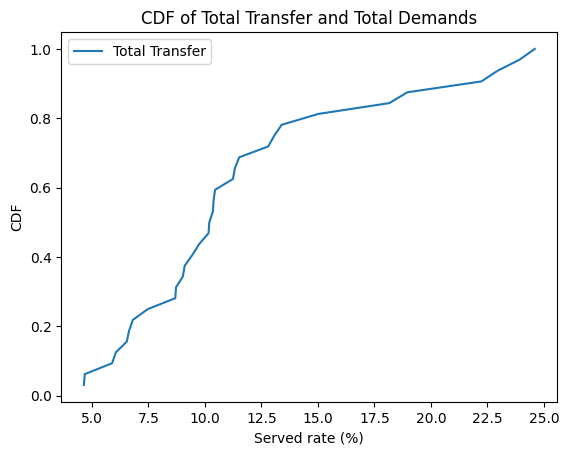

In [147]:
serve_rate_per_cell = total_transfer_per_cell / total_demands_per_cell * 100
# Calculate the CDF

sorted_serve_rate = np.sort(serve_rate_per_cell)
cdf = np.arange(1, len(sorted_serve_rate) + 1) / len(sorted_serve_rate)

# Plot the CDF
plt.plot(sorted_serve_rate, cdf, label='Total Transfer')
plt.xlabel('Served rate (%)')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Total Transfer and Total Demands')
plt.show()

## number of hops

In [67]:
results_dir = '../results/gw_4_fix_demands/traceroute/'
file_list = os.listdir(results_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

total_hops = 0

avg_hops_per_cell = [0 for x in cell_indices]
success_links = [0 for x in cell_indices]

for file in traceroute_files:
    cell = int(file.split('_')[2])
    with open(results_dir + file, 'r') as f:
        traceroute_output = f.read()
    traceroute_lines = traceroute_output.split('\n')[:-1]
    hops = 0
    failed = 0
    if len(traceroute_lines) < 2:
        failed = 1
        continue

    for line in traceroute_lines[1:]:
        if '*' not in line or ('*' in line and '*' not in traceroute_lines[-1]):
            hops += 1
        elif '*' in line and '*' in traceroute_lines[-1]:
            failed = 1
            break
        
    if failed == 0:
        avg_hops_per_cell[cell_indices.index(cell)] += hops
        success_links[cell_indices.index(cell)] += 1
        
    if 2 <= len(traceroute_lines) < 3:
        print (file)

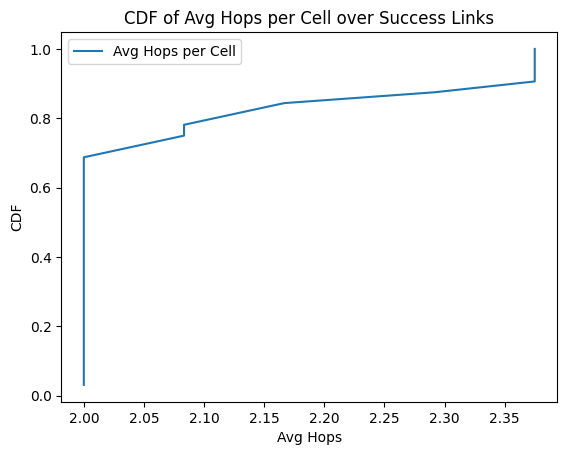

In [68]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate the CDF
sorted_avg_hops = np.sort(avg_hops_per_cell/np.array(success_links))
cdf = np.arange(1, len(sorted_avg_hops) + 1) / len(sorted_avg_hops)

# Plot the CDF
plt.plot(sorted_avg_hops, cdf, label='Avg Hops per Cell')
plt.xlabel('Avg Hops')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Avg Hops per Cell over Success Links')
plt.show()

## links load

In [ ]:
results_dir = '../results/gw_4_fix_demands/traceroute/'
file_list = os.listdir(results_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

total_hops = 0

sat_loads = [0 for x in range(200)]
sat_links = [0 for x in range(200)]

for file in traceroute_files:
    

## Network delay

## Unconneted cell rate